## 设置URL 以及 查询时间

In [1]:
import requests
import pandas as pd

# GraphQL 端点 URL
url = 'https://api.studio.thegraph.com/query/80234/mirror/v1'

# 设置查询日期
# 日期会影响查询数据的多少以及可视化的美观程度
start_date = "2018-01-01"
end_date = "2018-06-15"

In [2]:
import datetime

def date_to_timestamp(date_str):
    dt = datetime.datetime.strptime(date_str, "%Y-%m-%d")
    timestamp = int(dt.timestamp())
    return timestamp

## 定义 GraphQL 并 根据日期 查询全部数据

In [3]:
# 定义 GraphQL 查询模板
query = """
query getData($skipApprovals: Int!, $firstApprovals: Int!, $skipMints: Int!, $firstMints: Int!, $skipMintFinisheds: Int!, $firstMintFinisheds: Int!, $skipOwnershipTransferreds: Int!, $firstOwnershipTransferreds: Int!, $skipTransfers: Int!, $firstTransfers: Int!, $startTime: BigInt!, $endTime: BigInt!) {
  approvals(skip: $skipApprovals, first: $firstApprovals, orderBy: value, orderDirection: desc, where: {blockTimestamp_gte: $startTime, blockTimestamp_lte: $endTime}) {
    id
    owner
    spender
    value
    blockNumber
    blockTimestamp
    transactionHash
  }
  mints(skip: $skipMints, first: $firstMints, orderBy: amount, orderDirection: desc, where: {blockTimestamp_gte: $startTime, blockTimestamp_lte: $endTime}) {
    id
    to
    amount
    blockNumber
    blockTimestamp
    transactionHash
  }
  mintFinisheds(skip: $skipMintFinisheds, first: $firstMintFinisheds, orderBy: blockTimestamp, orderDirection: desc, where: {blockTimestamp_gte: $startTime, blockTimestamp_lte: $endTime}) {
    id
    blockNumber
    blockTimestamp
    transactionHash
  }
  ownershipTransferreds(skip: $skipOwnershipTransferreds, first: $firstOwnershipTransferreds, orderBy: blockTimestamp, orderDirection: desc, where: {blockTimestamp_gte: $startTime, blockTimestamp_lte: $endTime}) {
    id
    previousOwner
    newOwner
    blockNumber
    blockTimestamp
    transactionHash
  }
  transfers(skip: $skipTransfers, first: $firstTransfers, orderBy: value, orderDirection: desc, where: {blockTimestamp_gte: $startTime, blockTimestamp_lte: $endTime}) {
    id
    from
    to
    value
    blockNumber
    blockTimestamp
    transactionHash
  }
}
"""

def fetch_data(skipApprovals, firstApprovals, skipMints, firstMints, skipMintFinisheds, firstMintFinisheds, skipOwnershipTransferreds, firstOwnershipTransferreds, skipTransfers, firstTransfers, startTime, endTime):
    variables = {
        'skipApprovals': skipApprovals,
        'firstApprovals': firstApprovals,
        'skipMints': skipMints,
        'firstMints': firstMints,
        'skipMintFinisheds': skipMintFinisheds,
        'firstMintFinisheds': firstMintFinisheds,
        'skipOwnershipTransferreds': skipOwnershipTransferreds,
        'firstOwnershipTransferreds': firstOwnershipTransferreds,
        'skipTransfers': skipTransfers,
        'firstTransfers': firstTransfers,
        'startTime': startTime,
        'endTime': endTime
    }
    response = requests.post(url, json={'query': query, 'variables': variables})
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Query failed to run by returning code of {response.status_code}. {response.text}")

# 设置分页参数
first = 1000
skip_approvals = 0
skip_mints = 0
skip_mint_finisheds = 0
skip_ownership_transferreds = 0
skip_transfers = 0

all_approvals = []
all_mints = []
all_mint_finisheds = []
all_ownership_transferreds = []
all_transfers = []

# 设置时间过滤参数
start_time = date_to_timestamp(start_date) 
end_time = date_to_timestamp(end_date)  

while True:
    # 获取数据
    data = fetch_data(skip_approvals, first, skip_mints, first, skip_mint_finisheds, first, skip_ownership_transferreds, first, skip_transfers, first, start_time, end_time)
    
    approvals = data['data']['approvals']
    mints = data['data']['mints']
    mint_finisheds = data['data']['mintFinisheds']
    ownership_transferreds = data['data']['ownershipTransferreds']
    transfers = data['data']['transfers']
    
    # 添加数据到总列表中
    all_approvals.extend(approvals)
    all_mints.extend(mints)
    all_mint_finisheds.extend(mint_finisheds)
    all_ownership_transferreds.extend(ownership_transferreds)
    all_transfers.extend(transfers)
    
    # 检查是否所有数据都已经获取到
    if len(approvals) < first and len(mints) < first and len(mint_finisheds) < first and len(ownership_transferreds) < first and len(transfers) < first:
        break
    
    # 更新skip以获取下一页数据
    if len(approvals) == first:
        skip_approvals += first
    if len(mints) == first:
        skip_mints += first
    if len(mint_finisheds) == first:
        skip_mint_finisheds += first
    if len(ownership_transferreds) == first:
        skip_ownership_transferreds += first
    if len(transfers) == first:
        skip_transfers += first

# 打印获取到的所有数据
print(f"Total approvals fetched: {len(all_approvals)}")
print(f"Total mints fetched: {len(all_mints)}")
print(f"Total mint finished events fetched: {len(all_mint_finisheds)}")
print(f"Total ownership transferred events fetched: {len(all_ownership_transferreds)}")
print(f"Total transfers fetched: {len(all_transfers)}")

Total approvals fetched: 88
Total mints fetched: 295
Total mint finished events fetched: 0
Total ownership transferred events fetched: 0
Total transfers fetched: 694


In [4]:
# 转换为 DataFrame
# mint_events_df = pd.DataFrame(mint_events)
approvals_df = pd.DataFrame(all_approvals)
mints_df = pd.DataFrame(all_mints)
transfers_df = pd.DataFrame(all_transfers)

# 打印前几行数据
# print(mint_events_df.head())

## 画图，简单查看关系网络

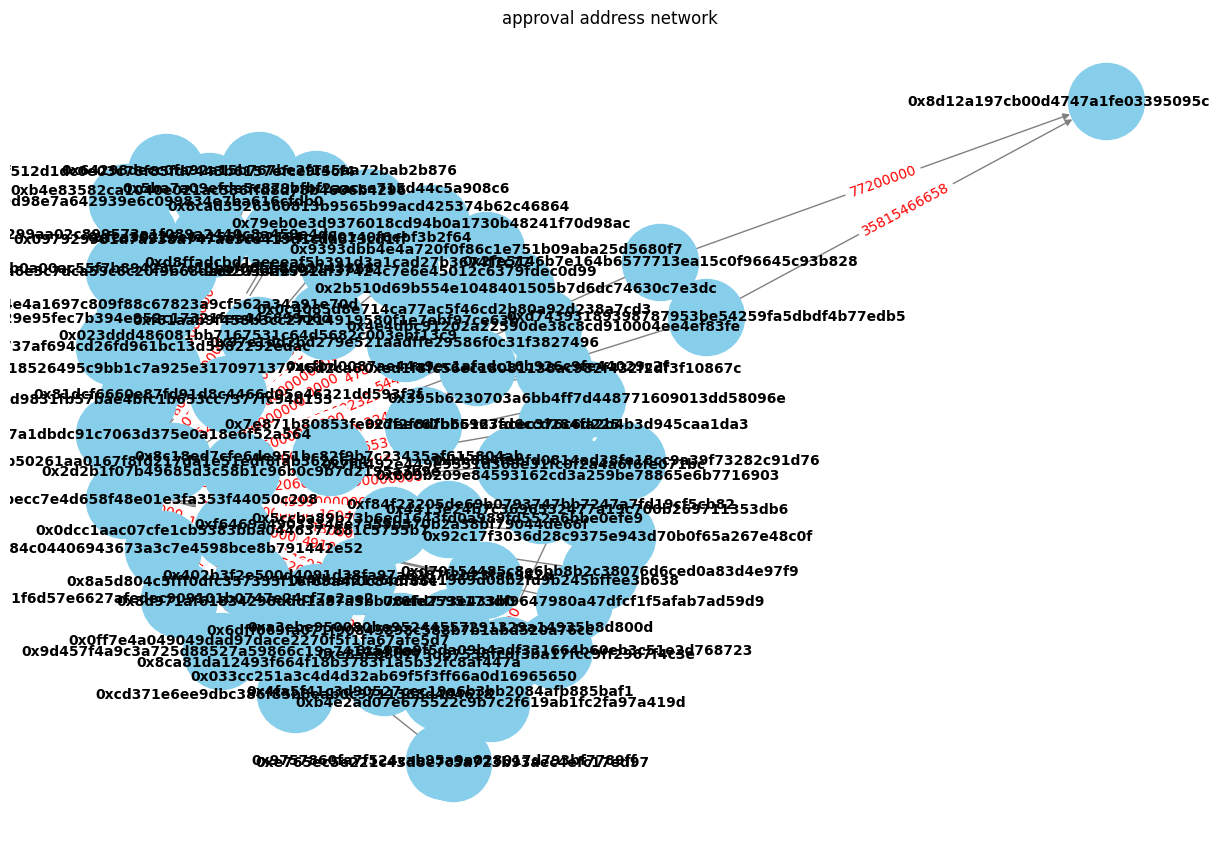

In [5]:
import networkx as nx
import matplotlib.pyplot as plt


# 创建一个有向图
G = nx.DiGraph()


# 添加边
for index, row in approvals_df.iterrows():
    G.add_edge(row['owner'], row['spender'], value=row['value'])

# 绘制图形
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")

# 显示边上的权重（可选）
edge_labels = {(row['owner'], row['spender']): row['value'] for index, row in approvals_df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

plt.title("approval address network")
plt.show()

## 网页显示

In [6]:
import pandas as pd
import networkx as nx
import plotly.graph_objs as go
from plotly.offline import plot, iplot


def create_network_figure(df, title, source_col, target_col, value_col):
    # 创建一个有向图
    G = nx.DiGraph()

    # 添加边
    for index, row in df.iterrows():
        G.add_edge(row[source_col], row[target_col], value=row[value_col])

    # 计算节点位置
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # 提取节点和边的位置
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=1, color='gray'),
        hoverinfo='text',
        mode='lines',
        text=[]
    )

    edge_labels = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='text',
        hoverinfo='none'
    )

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += (x0, x1, None)
        edge_trace['y'] += (y0, y1, None)
        
        # 边的中点
        x_middle = (x0 + x1) / 2
        y_middle = (y0 + y1) / 2
        edge_labels['x'] += (x_middle,)
        edge_labels['y'] += (y_middle,)
        edge_labels['text'] += (edge[2]['value'],)

    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    for node in G.nodes():
        x, y = pos[node]
        node_trace['x'] += (x,)
        node_trace['y'] += (y,)
        node_trace['text'] += (node,)

    # 绘制图形
    fig = go.Figure(data=[edge_trace, edge_labels,node_trace],
                    layout=go.Layout(
                        title=f'<br>{title}',
                        titlefont=dict(size=16),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper"
                        )],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        dragmode='zoom'))  # 启用鼠标缩放
    return fig

# 创建 Transfer 图形
transfer_fig = create_network_figure(transfers_df, "Transfers " + start_date  + "-" + end_date, "from", "to", "value")

# 创建 Approval 图形
approval_fig = create_network_figure(approvals_df, "Approvals" + start_date  + "-" + end_date, "owner", "spender", "value")

# 显示图形
plot(transfer_fig, filename='transfer_network_graph.html', auto_open=False)
plot(approval_fig, filename='approval_network_graph.html', auto_open=False)



'approval_network_graph.html'

In [7]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import plot


# 将时间戳转换为 datetime 类型
mints_df['blockTimestamp'] = pd.to_datetime(mints_df['blockTimestamp'], unit='s')


# 将 amount 转换为数值类型并
decimals = 18
mints_df['amount'] = mints_df['amount'].astype(float) / 10 ** decimals

# 统计每月的 amount
mints_df['month'] = mints_df['blockTimestamp'].dt.to_period('M').astype(str)
monthly_amount = mints_df.groupby('month')['amount'].sum().reset_index()

# 统计每周的 amount
mints_df['week'] = mints_df['blockTimestamp'].dt.to_period('W').astype(str)
weekly_amount = mints_df.groupby('week')['amount'].sum().reset_index()

# 创建每月的 amount 图表
monthly_fig = px.bar(monthly_amount, x='month', y='amount', title='Monthly Mint Amount')

# 创建每周的 amount 图表
weekly_fig = px.bar(weekly_amount, x='week', y='amount', title='Weekly Mint Amount')

# 保存图表为 HTML 文件
monthly_fig.write_html("monthly_mint_amount.html", auto_open=False)
weekly_fig.write_html("weekly_mint_amount.html", auto_open=False)


# 将所有图形合并到同一个网页
html_content = f"""
<html>
<head>
    <title>Network Graphs</title>
</head>
<body>
    <h1>Transfers Network Graph</h1>
    <iframe src="transfer_network_graph.html" width="100%" height="600"></iframe>
    <h1>Approvals Network Graph</h1>
    <iframe src="approval_network_graph.html" width="100%" height="600"></iframe>
    <h1>Monthly Mint Amount</h1>
    <iframe src="monthly_mint_amount.html" width="100%" height="600"></iframe>
    <h1>Weekly Mint Amount</h1>
    <iframe src="weekly_mint_amount.html" width="100%" height="600"></iframe>
</body>
</html>
"""

with open("combined_network_graphs.html", "w") as f:
    f.write(html_content)


In [8]:
# 打开合并的网页
import webbrowser
webbrowser.open(f"./combined_network_graphs.html")

True